# Practice - Naive Bayes - Predicting Amazon Review Sentiment on Music #

## by Lorenz Madarang ##

## Data: http://jmcauley.ucsd.edu/data/amazon/ ##

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import re
from string import punctuation
from collections import Counter
import operator
from sklearn import linear_model
import statsmodels.formula.api as smf

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

### Data Ingestion and Model Prep ###
For this data, I used a Naive Bayes model to predict the sentiment of the Amazon review of music.  I created a target feature titled "sentiment_cat."  This feature indicated whether or not the review had a score of 2.0 or less.  I used the words in the reviewText feature to predict whether the rating had a score of less than 2.0.  I created a word list of the words used in the reviews that had a score of less than 2.0 and then I created a dictionary of the words and their associated counts.  I looked to see what were the most populat negative connotation words and created a negative connotation keword list to be used for our Naive Bayes classifier. The words I put in the keyword list were: 'but', 'not', 'off', 'back', 'never', 'nothing', 'worst', 'little', 'boring', 'trying', 'crap', 'horrible', 'waste', 'terrible', and 'awful'.

In [3]:
amazon = pd.read_json('reviews_CDs_and_Vinyl_5.json', lines=True)

In [4]:
amazon.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0307141985,"[14, 15]",5,I don't know who owns the rights to this wonde...,"10 6, 2005",A3IEV6R2B7VW5Z,J. Anderson,LISTEN TO THE PUBLIC!!!,1128556800
1,0307141985,"[2, 2]",4,Thanksgiving is devoid of icons to make it a f...,"11 23, 2011",A2H3ISQ4QB95XN,Joseph Brando,Rankin/Bass Does Thanksgiving!!,1322006400
2,0307141985,"[38, 38]",5,This is a Thanksgiving tale that begins with t...,"07 14, 2003",A6GMEO3VRY51S,microjoe,Thanksgiving Holiday fun from Rankin/Bass,1058140800
3,0307141985,"[15, 16]",5,This is the BEST THANKSGIVING special around.....,"11 6, 2003",A3E102F6LPUF1J,"Richard J. Goldschmidt ""Rick Goldschmidt""",BEST THANKSGIVING special out there!,1068076800
4,0307141985,"[11, 12]",5,It's been a number of years since I've seen Mo...,"03 1, 2006",A2JP0URFHXP6DO,Tim Janson,A THANKSGIVING TRADITION,1141171200


In [20]:
amazon.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1097592 entries, 0 to 1097591
Data columns (total 9 columns):
asin              1097592 non-null object
helpful           1097592 non-null object
overall           1097592 non-null int64
reviewText        1097592 non-null object
reviewTime        1097592 non-null object
reviewerID        1097592 non-null object
reviewerName      1094651 non-null object
summary           1097592 non-null object
unixReviewTime    1097592 non-null int64
dtypes: int64(2), object(7)
memory usage: 83.7+ MB


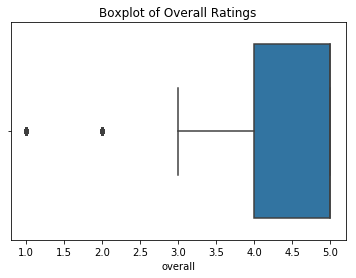

In [7]:
x = amazon['overall']
plt.title('Boxplot of Overall Ratings')
sns.boxplot(x)

In [9]:
lessthan_2 = amazon[(amazon['overall'] < 2)]

In [10]:
lessthan_2.shape[0]

46195

In [16]:
lessthan_2.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
10,073890015X,"[2, 2]",1,This would be the perfect event to put on DVD....,"10 21, 1999",A1THF19PO0LXRD,James Marsh,Where's the DVD???,940464000
33,0738900672,"[6, 31]",1,"I might get ripped for this review, but i hone...","07 27, 2004",A110L6QITPVJTP,B.Huss,Can't see the hype,1090886400
98,0760135002,"[1, 5]",1,Whatever it Takes is my pick for the worst tee...,"09 24, 2000",A379BEI7Z151X7,dan,lousy,969753600
104,0760135002,"[1, 3]",1,This is truly one of the worst movies I have e...,"11 22, 2000",A1935MTY2YEK5X,JT,Horrible!,974851200
137,076783822X,"[2, 18]",1,I was hoping this would be a decent video abou...,"12 2, 2002",A1E9N5FK21NDTD,"APIMom1999 ""wolfsky""",Loose the stick dancers,1038787200


In [13]:
word_list = []

In [14]:
for index, row in lessthan_2.iterrows():
    message = row['reviewText']
    r = re.compile(r'[{}]'.format(punctuation))
    new_strs = r.sub(' ', message)
    for word in new_strs.split():
        word_list.append(word)

In [17]:
word_dict = Counter(word_list)

In [32]:
keywords = ['but', 'not', 'off', 'back', 'never', 'nothing', 'worst', 'little', 
            'boring', 'trying', 'crap', 'horrible', 'waste', 'terrible', 'awful']

In [25]:
sentiment_cat = []

In [26]:
for i in range(0, 1097592):
    if amazon.loc[i, 'overall'] < 2.0:
        sentiment_cat.append(1)
    else:
        sentiment_cat.append(0)

In [29]:
amazon['sentiment_cat'] = sentiment_cat

In [34]:
for key in keywords:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    amazon[str(key)] = amazon.reviewText.str.contains(
        ' ' + str(key) + ' ',
        case=False
    )

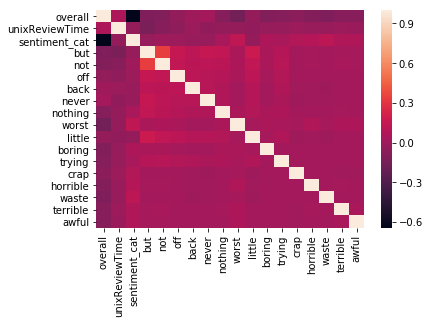

In [35]:
sns.heatmap(amazon.corr())

### Naive Bayes Model ###
At the initial look of the model, it looks like the model is performing pretty well with an accuracy score of 95%.  This accuracy also holds when we split the data into training and test.  The score also holds when we do a cross-validation with 10 folds.  But when we look at the sensitivity and specificity it doesn't look so good.  The model does not perform well in being able to identify which ones have a score of less than 2.0.  The model has a very nice specificity.  But if the model just predicted that the review is not less than 2.0 than it would be 95% accurate.  The sensitivity is the best indicator of how well the model performed and it didn't perform too well.  

In [36]:
data = amazon[keywords]
target = amazon['sentiment_cat']

In [37]:
# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))

Number of mislabeled points out of a total 1097592 points : 47084


In [38]:
from sklearn.model_selection import train_test_split

# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(bnb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(bnb.fit(data, target).score(data, target)))

With 20% Holdout: 0.957106218596
Testing on Sample: 0.957102457015


In [39]:
from sklearn.model_selection import cross_val_score
cross_val_score(bnb, data, target, cv=10)

array([ 0.9578535 ,  0.95717019,  0.95769862,  0.95770773,  0.95740707,
        0.95639538,  0.95585783,  0.9559121 ,  0.95662275,  0.95772518])

In [40]:
from sklearn.metrics import confusion_matrix
confusion_matrix(target, y_pred)

array([[1048298,    3099],
       [  43985,    2210]])

In [41]:
matrix = confusion_matrix(target, y_pred)
print('Sensitivity is {}'.format(matrix[1,1]/(matrix[0,1]+matrix[1,1])))
print('Specificity is {}'.format(matrix[0,0]/(matrix[0,0]+matrix[1,0])))

Sensitivity is 0.41627425127142587
Specificity is 0.9597311319502363


In [43]:
1 - (lessthan_2.shape[0])/len(amazon) 

0.9579124118980459